In [67]:
import torch
from torch.utils.data import Subset,DataLoader, TensorDataset, ConcatDataset
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

In [68]:
batch_size = 64
num_classes = 10
epochs = 20
device = "cuda" if torch.cuda.is_available() else "cpu"

In [69]:
train_set = datasets.FashionMNIST('/content',train=True,download=True)
test_set = datasets.FashionMNIST('/content',train=False,download=True)

### Preprocessing

In [70]:
# inversion and normalization
invert = lambda image : 1 - image # function to invert the image
normalize = lambda image : image / 255 # function for bringing pixel values in range [0,1]

def preprocessing(dataset):
    dataset_images = dataset.data.numpy() # convert the dataset into numpy array
    dataset_labels = dataset.targets.numpy() # convert the labels into numpy array
    dataset_images = normalize(dataset_images)
    dataset_images = invert(dataset_images)
    return dataset_images,dataset_labels

train_images,train_labels = preprocessing(train_set)
test_images,test_labels = preprocessing(test_set)

### Prepare the data

In [71]:
def generate_labels(dataset_images,image_type):
  labels = np.full(shape=(dataset_images.shape[0]),fill_value=[image_type])
  return labels

# function to prepare the dataset for a given digit
def prepare_training_data(dataset_images,dataset_labels,class_num,amount):
    positive_indices = np.asarray(np.where(dataset_labels == class_num)) # indices of occurrence of digit as label
    positive_indices = positive_indices.flatten()
    # get the images for making positive dataset
    dataset_images_positive = dataset_images[positive_indices] # images consisting of positive class
    dataset_labels_positive = generate_labels(dataset_images_positive,0) # generate the class labels
    print(f"Positive train data shape: {dataset_images_positive.shape}")
    negative_indices = np.asarray(np.where(dataset_labels != class_num))
    negative_indices = negative_indices.flatten()
    np.random.shuffle(negative_indices)
    print(len(negative_indices))
    negative_indices = negative_indices[:amount]
    print(len(negative_indices))
    # get the images for making negative dataset
    dataset_images_negative = dataset_images[negative_indices]
    dataset_labels_negative = generate_labels(dataset_images_negative,1)
    print(f"Negative train data shape: {dataset_images_negative.shape}")
    # concatenate the negative and positive datasets
    modified_dataset_images = np.concatenate((dataset_images_positive,dataset_images_negative))
    modified_dataset_labels = np.concatenate((dataset_labels_positive,dataset_labels_negative))
    tensor_x = torch.Tensor(modified_dataset_images)
    tensor_y = torch.Tensor(modified_dataset_labels)
    new_dataset = TensorDataset(tensor_x,tensor_y.to(torch.int64))
    return new_dataset

def prepare_testing_data(dataset_images,dataset_labels,class_num):
  positive_indices = np.asarray(np.where(dataset_labels == class_num)) # indices of occurrence of digit as label
  positive_indices = positive_indices.flatten()
  # get the images for making positive dataset
  dataset_images_positive = dataset_images[positive_indices] # images consisting of positive class
  dataset_labels_positive = generate_labels(dataset_images_positive,0) # generate the class labels
  print(f"Positive test data shape: {dataset_images_positive.shape}")
  # get the images for making negative classes for testing
  negative_indices = np.asarray(np.where(((dataset_labels != class_num))))
  negative_indices = negative_indices.flatten()
  # get the images for making negative dataset
  dataset_images_negative = dataset_images[negative_indices]
  dataset_labels_negative = generate_labels(dataset_images_negative,1)
  print(f"Negative test data shape: {dataset_images_negative.shape}")
  # concatenate the negative and positive datasets
  modified_dataset_images = np.concatenate((dataset_images_positive,dataset_images_negative))
  modified_dataset_labels = np.concatenate((dataset_labels_positive,dataset_labels_negative))
  tensor_x = torch.Tensor(modified_dataset_images)
  tensor_y = torch.Tensor(modified_dataset_labels)
  new_dataset = TensorDataset(tensor_x,tensor_y.to(torch.int64))
  return new_dataset

Positive train data shape: (6000, 28, 28)
54000
20000
Negative train data shape: (20000, 28, 28)
Positive test data shape: (1000, 28, 28)
Negative test data shape: (9000, 28, 28)
tensor([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1,
        1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1])


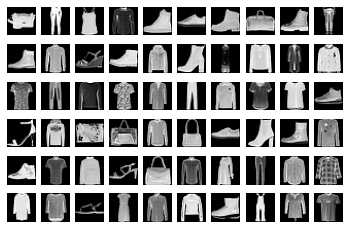

In [72]:
class_num = 6
amount = 20000
train_class_set = prepare_training_data(train_images,train_labels,class_num,amount) # fetch the training set for a class
test_class_set = prepare_testing_data(test_images,test_labels,class_num)
train_loader = DataLoader(train_class_set,batch_size=64,shuffle=True)
test_loader = DataLoader(test_class_set,batch_size=64,shuffle=True) # take original testing set of all classes
dataiter = iter(train_loader)
images,labels = dataiter.next()
figure = plt.figure()
print(labels)
num_of_images = 60
for index in range(1,num_of_images+1):
  plt.subplot(6,10,index)
  plt.axis('off')
  plt.imshow(images[index].numpy().squeeze(),cmap='gray_r')

### Define the network

In [73]:
class NeuralNetwork(nn.Module):
  def __init__(self,classes,channels):
    super().__init__()
    self.conv1 = nn.Conv2d(channels,6,5)
    self.conv2 = nn.Conv2d(6,16,5)
    self.pool = nn.MaxPool2d(2,2)
    self.fc1 = nn.Linear(16*4*4,128)
    self.fc2 = nn.Linear(128,64)
    self.fc3 = nn.Linear(64,classes)
  
  def forward(self,x):
    x = x.unsqueeze(1)
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(x.shape[0],-1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    # x = F.softmax(x,dim=1)
    return x

### Training the model

In [74]:
def train(model,trainloader):
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(),lr=0.001,momentum=0.9)
  model.train()
  for e in range(epochs):
    running_loss = 0.0
    for _,(images,labels) in enumerate(trainloader):
      optimizer.zero_grad()

      output = model(images)
      loss = criterion(output,labels)

      loss.backward()
      optimizer.step()
      running_loss += loss.item()
    # else:
    #   print(f"Training loss: {running_loss / len(trainloader)}")
  return model

### Testing the model

In [75]:
def test(model,testloader,classes):
  correct = np.zeros(classes,dtype=np.float64)
  total = np.zeros(classes,dtype=np.float64)

  with torch.no_grad():
    for images,labels in testloader:
      output = model(images)
      pred = torch.argmax(output,dim=1)
      for i in range(len(labels)):
        correct[labels[i]] += (pred[i] == labels[i])
        total[labels[i]] += 1
  # print(f"Accuracy for {classes} classes: {np.sum(correct) / np.sum(total)}")
  return (np.sum(correct) / np.sum(total),correct,total)

### Prepare initial training set

In [76]:
# x = np.linspace(20000,30000,11)
# amount = 20000
# for amount in x:
train_class_set = prepare_training_data(train_images,train_labels,class_num,int(amount)) # fetch the training set for a class
test_class_set = prepare_testing_data(test_images,test_labels,class_num)
train_loader = DataLoader(train_class_set,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_class_set,batch_size=batch_size,shuffle=True) # take original testing set of all classes
model = NeuralNetwork(2,1)
model = train(model,train_loader)
accuracies = test(model,test_loader,2)
print(f"Accuracy for {amount} images of negative class {accuracies[0]}")
print(accuracies[1],accuracies[2])

Positive train data shape: (6000, 28, 28)
54000
20000
Negative train data shape: (20000, 28, 28)
Positive test data shape: (1000, 28, 28)
Negative test data shape: (9000, 28, 28)
Accuracy for 20000 images of negative class 0.9035
[ 707. 8328.] [1000. 9000.]


### Plot the accuracy variation for class 0

In [77]:
# x = np.linspace(0,10,num=9)
# plt.plot(x,accuracy_change_0,'-s',label = 'Class 0')
# plt.plot(x,accuracy_change_1,'-s',label = 'Class 1')
# plt.legend()
# plt.title("Accuracy fluctuation")
# plt.show()